# Training a SVM with gradient descent

In this notebook I show how to derivate an algorithm to train a SVM using projected gradient descent. In practice SVM are trained using more nuance algorithms like [SMO](https://en.wikipedia.org/wiki/Sequential_minimal_optimization). However as suggested in [CIML](http://ciml.info/), SVMs can also be trained using projected gradient descent.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from models.svm import SVM
from utils.datasets import blobs_classification_dataset, radial_classification_dataset
from utils.visualization import plot_decision_boundary

In [2]:
%matplotlib inline

# Turn interactive plotting off
plt.ioff()

# Reproducibility
np.random.seed(1)

## Optimal separating hyperplane

The goal is to find the hyperplane that better separates some data according to their binary label. Let's take the following data.

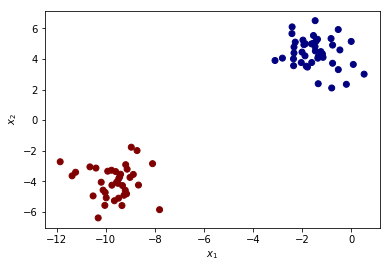

In [3]:
(x_train, y_train), (x_test, y_test) = blobs_classification_dataset(features=2, classes=2)
# Turn labels from {0,1} to {-1,1}
y_train += y_train-1
y_test += y_test-1

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

We want to find the line that better separates both clusters

### The perceptron:
To solve this problem the perceptron algorithms initiliazed randomly some separating hyperplane $x^T\beta + \beta_0 = 0$ and iterate over the training points to adjust the parameters $\beta$. For each point it computes the predicted label, and if the prediction is incorrect we take a step in the negative direction of the gradient. We are minimizing the distance of the missclassified points to the margin. The perceptron predict the class of a point $x_i$ as:
$$
\hat{y} = \text{sign}(x_i^T\beta + \beta_0 = 0)
$$

To minimize the margin we wan to minimize the expression:
$$
L(\beta, \beta_0) = -\sum_{i \in \mathit{M}}y_i(x_i^T\beta + \beta_0 = 0)
$$
where $\mathit{M}$ is the set of missclassified data examples.

Taking gradients:
$$
\frac{\partial{L}}{\partial{\beta}} = -\sum_{i \in \mathit{M}}y_ix_i \\
\frac{\partial{L}}{\partial{\beta_0}} = -\sum_{i \in \mathit{M}}y_i
$$

We train using stochastic gradient descent, this is, using one example at a time.

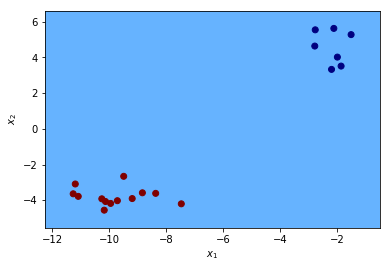

In [4]:
# Initialize separating line
beta = np.random.rand(2)
beta0 = 0.0

def predict(x):
    return np.sign(np.dot(x, beta) + beta0)

# Plot initial separating line
ax = plot_decision_boundary(lambda x: np.clip(predict(x), 0, 1),
                            x_range=[x_test[:, 0].min()-1, x_test[:, 0].max()+1],
                            y_range=[x_test[:, 1].min()-1, x_test[:, 1].max()+1])
# Plot test data
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='jet')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

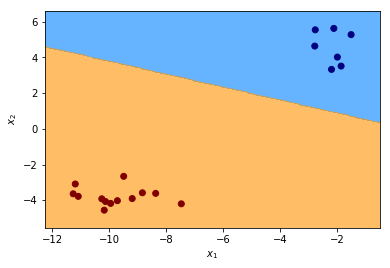

In [5]:
# Train the perceptron until convergence
converged = False
while(not converged):
    converged = True
    for i in range(x_train.shape[0]):
        predicted = predict(x_train[i, :])
        if predicted != y_train[i]:
            converged = False
            beta += 0.1*x_train[i, :]*y_train[i]
            beta0 += 0.1*y_train[i]
    

# Plot separating line after training
ax = plot_decision_boundary(lambda x: np.clip(predict(x), 0, 1),
                            x_range=[x_test[:, 0].min()-1, x_test[:, 0].max()+1],
                            y_range=[x_test[:, 1].min()-1, x_test[:, 1].max()+1])
# Plot test data
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='jet')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

The problem with the perceptron is that it is not guaranteed to converge to any good solution when data is not lineary separable, moreover it does not find the optimal separating hyperplane, it converges whenever the plane is good enough to separate the training data. If we want to generalize as much as possible we need another approach.

## Maximizing the margin

The most simple version of the SVM is the problem of finding the optimal separating hyperplane between 2 classes which are lineary separable. The optimal plane is that that maximizes the margin M defined as the distance from the plane to its closest point in the training set. Let $f(x) = x^T\beta + \beta_0 = 0$ be the separating hyperplane. Then we can solve the optimization problem:
$$
\max_{\beta, \beta_0, \|\beta\|=1} M \\
\text{subject to: } y_i(x_i^T\beta + \beta_0) \geq M, i=1,2,..,N
$$
where $y_i \in {-1, 1}$ is the label of the $i$-th training example $x_i$. 

Noting that the distance from a point $x_i^\prime$ to a hyperplane $x^T\beta^\prime + \beta_0^\prime = 0$ is $\frac{|x_i^{\prime T}\beta^\prime + \beta_0^\prime|}{\|\beta^\prime\|}$, the original problem without noise can be interpreted as maximizing the minimum distance($M$) from each point in the data to the separating plane. Setting $M$ as $\frac{1}{\|\beta\|}$ the problem can be rewritte as:
$$
\min_{\beta, \beta_0} \frac{1}{2}\|\beta\|^2 \\
\text{subject to: } y_i(x_i^T\beta + \beta_0) \geq 1, i=1,2,..,N
$$

The problem is reduced to optimizing a quadratic function, with just one single minimum, subject to some constraint. This constrained optimization problem can be solved using a method called the [Lagrangian multiplier](https://en.wikipedia.org/wiki/Lagrange_multiplier), a good explanation is given in [Khan Academy](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/lagrange-multipliers-and-constrained-optimization). This method incorporates the constrain along with the objective function into the same expression. Moreover, the Lagrangian multiplier method allows to solve optimization problems with equality constraints, in order to incorporate the inequality constraint the [KKT conditions](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions) must also be met. The Lagrange primal function of the problem is:
$$
L_P = \frac{1}{2}\|\beta\|^2 - \sum_{i=1}^N\alpha_i[y_i(x_i^T\beta + \beta_0) - 1]
$$

Setting derivatives to $0$:
$$
\beta = \sum_{i=1}^{N}\alpha_iy_ix_i \\
0 = \sum_{i=1}^{N}\alpha_iy_i
$$

and substituting:
$$
L_D = \sum_{i=1}^{N}\alpha_i - \frac{1}{2}\sum_{i=1}^{N}\sum_{i=k}^{N}\alpha_i\alpha_ky_iy_kx_i^Tx_k \\
\text{subject to: } \alpha_i \geq 0, i=1,2,..,N
$$

The solution is obtained by maximizing $L_D$, which is the dual form. To satisfy the KKT conditions the following constraint:
$$
\alpha_i[y_i(x_i^T\beta + \beta_0) - 1] = 0, \forall i
$$

## The kernel trick
Having defined the objective function in terms of the dot product of the data points, we can substitute it by a kernel function:
$$
L_D = \sum_{i=1}^{N}\alpha_i - \frac{1}{2}\sum_{i=1}^{N}\sum_{i=k}^{N}\alpha_i\alpha_ky_iy_kK(x_i, x_k) \\
$$

The predicted category of a new point $x^\prime$ is computed as:
$$
\hat{y} = \text{sign}(\sum_{i=1}^{N}\alpha_iy_iK(x_i, x^\prime) + b)
$$

## Optimizing the dual form

The objective dual form can be optimized using a projected version of gradient descent. The idea is to perform gradient descent, but after performing each training step, the variables should be tunned in order to meet the conditions, in this case setting $\alpha_i := 0, \forall i : \alpha_i < 0$.

Taking the dual form in matrix form we have:
$$
L_D = \alpha^T\mathbf{1} - \frac{1}{2}\alpha^TG\alpha \\
G_{ij} = y_iy_jK(x_i, x_j)
$$

Taking the derivative:
$$
\frac{\partial{L_D}}{\partial{\alpha}} = \mathbf{1} - \frac{1}{2}\alpha^T(G+G^T) = \mathbf{1} - \alpha^TG
$$
Notice that we can perform the last step because G is symmetric.

One migh be tempted to set the drivative to $0$ and compute the analytic solution. But this doesn't take into account the constraints, one can enforced them after computing the multipliers but then the solution is no longer guarateed to be the optimal.

Enforcing the conditions at each gradient update we ensure that the conditions are meet and that we converge to an optimum.

We may now solve the above problem, even with more complex data distributions:

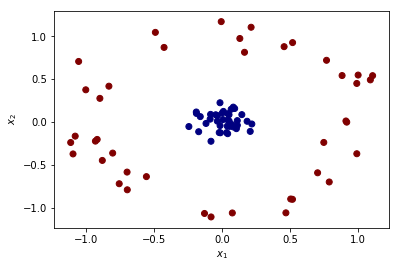

In [6]:
(x_train, y_train), (x_test, y_test) = radial_classification_dataset()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.show()

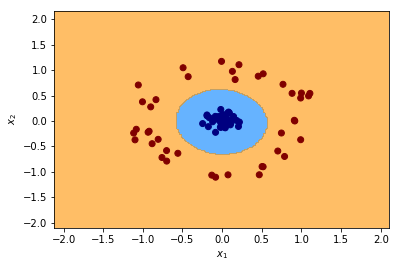

In [7]:
# Train SVM
quadratic_model = SVM(kernel='quadratic')
loss = quadratic_model.fit(x_train, y_train, iterations=10000, learning_rate=0.01)

# Plot decision boundary
ax = plot_decision_boundary(quadratic_model.predict,
                            x_range=[x_train[:, 0].min()-1, x_train[:, 0].max()+1],
                            y_range=[x_train[:, 1].min()-1, x_train[:, 1].max()+1])
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## Dealing with noise: Hinge Loss
To deal with non-separable data, or simply with noisy points that fall on the other side of the real boundary, we can include a cost parameter $C$:
$$
\min_{\beta, \beta_0} \frac{1}{2}\|\beta\|^2 + C\sum_{i=1}^{N}\xi_i\\
\text{subject to: } \xi_i \geq 0, y_i(x_i^T\beta + \beta_0) \geq 1-\xi_i, \forall i
$$
where $\xi_i$ are slack variables proportional to the amount by which each point $x_i$ falls on the wrong side of its margin.
The total amount of slack cannot surpass $\frac{1}{C}$.

Following the same procedure of Lagragian multiplier and taking the primal and dual forms we arrive at the same objective function, but with a harder constraint:
$$
L_D = \sum_{i=1}^{N}\alpha_i - \frac{1}{2}\sum_{i=1}^{N}\sum_{i=k}^{N}\alpha_i\alpha_ky_iy_kK(x_i, x_k) \\
\text{subject to: } 0 \leq \alpha_i \leq C, \forall i
$$

With these cost penalty $C$ we can train a classifier dealing with noisy training data: 

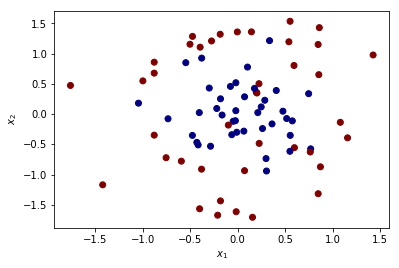

In [8]:
(x_train, y_train), (x_test, y_test) = radial_classification_dataset(noise=0.5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.show()

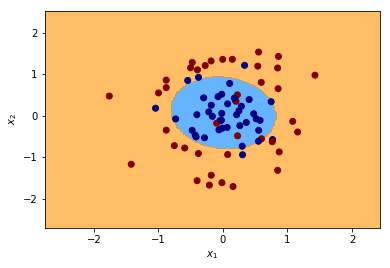

In [9]:
# Train SVM
quadratic_model = SVM(kernel='quadratic', C=5)
loss = quadratic_model.fit(x_train, y_train, iterations=10000, learning_rate=0.01)

# Plot decision boundary
ax = plot_decision_boundary(quadratic_model.predict,
                            x_range=[x_train[:, 0].min()-1, x_train[:, 0].max()+1],
                            y_range=[x_train[:, 1].min()-1, x_train[:, 1].max()+1])
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## Bibliography

* [ESL](http://web.stanford.edu/~hastie/ElemStatLearn/)
* [An Idiot's guide to Support vector machines](http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf)
* [A Course in Machine Learning](http://ciml.info/)
* [Khan Academy](https://www.khanacademy.org/)